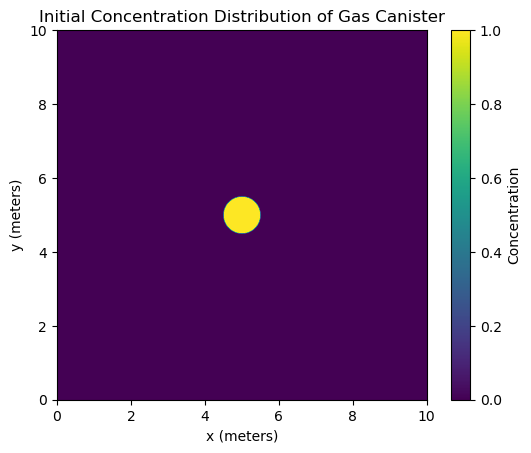

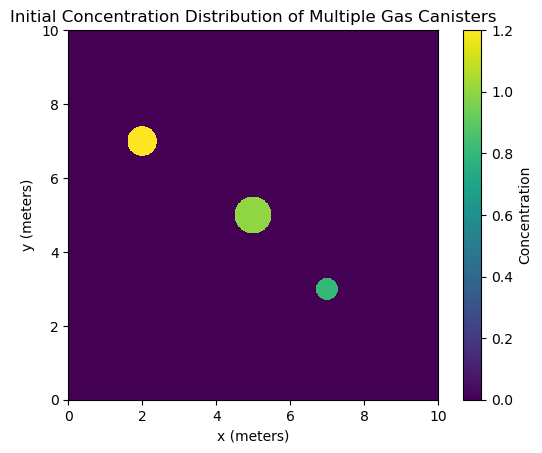

In [ ]:
# ==========================================================================================
# Importing Packages:
# ==========================================================================================

import numpy as np
import scipy.sparse as sp
from scipy.sparse import vstack, csr_matrix, diags, eye, kron
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

# ==========================================================================================
# Spatial Dimensions:
# ==========================================================================================

# Length and width of the Room:
Lx = 10 # Length is 10 meters
Ly = 10 # Width is 10 meters

# Discretization of the room dimensions:
Nx_spaces = 1000  # Number of spaces in x (length)
Ny_spaces = 1000  # Number of spaces in y (width)
Nx_points = Nx_spaces + 1 # Number of points in x (length)
Ny_points = Ny_spaces + 1 # Number of points in y (width)

# Creating a grid of the room:
    
# From 0 to Lx define Nx_points evenly spaced
x = np.linspace(0, Lx, Nx_points)

# From 0 to Ly define Ny_points evenly spaced
y = np.linspace(0, Ly, Ny_points)

# ==========================================================================================
# Gas Canister(s)
# ==========================================================================================

class GasCan2D:
    def __init__(self, x_loc, y_loc, radius, concentration):

        self.concentration = concentration        # Initial concentration in the canister
        self.x_loc = x_loc                        # x-coordinate of the canister's center (in meters)
        self.y_loc = y_loc                        # y-coordinate of the canister's center (in meters)
        self.radius = radius                      # Radius of the canister

    def get_initial_concentration(self, x, y):

        # Create a meshgrid of the x-y plane to apply masks over
        X, Y = np.meshgrid(x, y, indexing='ij')

        # Create a boolean mask for equation of a circle, i.e the equation of the points where canister sits on the xy-plane
        mask = (X - self.x_loc)**2 + (Y - self.y_loc)**2 <= self.radius**2

        # Create a grid to hold concentration values
        concentration_grid = np.zeros_like(X, dtype=float)

        # Set the concentration in the masked area
        concentration_grid[mask] = self.concentration

        # Returns a grid which is essentially an Nx_points * 
        return concentration_grid

# Creating an instance of the GasCan2D class
mycan = GasCan2D(x_loc=5, y_loc=5, radius=0.5, concentration=1.0)

# Get initial concentration distribution from the gas canister
initial_concentration_grid = mycan.get_initial_concentration(x, y)

plt.imshow(initial_concentration_grid, extent=[0, Lx, 0, Ly], origin='lower', cmap='viridis')
plt.colorbar(label='Concentration')  # Add a color bar to indicate concentration levels
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.title('Initial Concentration Distribution of Gas Canister')

# Display the plot  to show the initial canister in the xy-plane
plt.show()  

# Let us define multiple canisters
canisters_2d = [
    GasCan2D(x_loc=5.0, y_loc=5.0, radius=0.5, concentration=1.0),
    GasCan2D(x_loc=3.0, y_loc=7.0, radius=0.3, concentration=0.8),
    GasCan2D(x_loc=7.0, y_loc=2.0, radius=0.4, concentration=1.2),
]

# Initialize the total concentration grid
initial_concentration_grid = np.zeros((Nx_points, Ny_points), dtype=float)

# Loop through each canister and add its concentration to the total grid
for canister in canisters_2d:
    initial_concentration_grid += canister.get_initial_concentration(x, y)

# Plot the resulting concentration grid
plt.imshow(initial_concentration_grid, extent=[0, Lx, 0, Ly], origin='lower', cmap='viridis', interpolation='none')
plt.colorbar(label='Concentration')  # Add a color bar to indicate concentration levels
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.title('Initial Concentration Distribution of Multiple Gas Canisters')

plt.show()  

# ==========================================================================================
# Scrubber(s)
# ==========================================================================================

class Scrubber2D():
    def __init__(self, x_loc, y_loc, radius, efficiency, cap):
        
        self.x_loc = x_loc                          # Central x location of the scrubber
        self.y_loc = y_loc                          # Central y location of the scrubber
        self.radius = radius                        # Radius of the scrubber
        self.efficiency = efficiency                # Efficiency of the scrubber to absorb gas

        # Possible implementation of scrubber capacity?
        # self.cap = cap                              # Maximum concentration that can be absorbed
        # self.current_load = 0                       # Current concentration absorbed so far

    def get_affected_indices(self, x, y):

        # Create a meshgrid of the x-y plane to apply masks over
        X, Y = np.meshgrid(x, y, indexing='ij')

        # Create a boolean mask for equation of a circle, i.e the equation of the points where canister sits on the xy-plane
        mask = (X - self.x_loc)**2 + (Y - self.y_loc)**2 <= self.radius**2
    
        return mask

# List of scrubbers in 2D
scrubbers_2d = [
    Scrubber2D(x_loc=0.8, y_loc=0.8, radius=0.02, efficiency=0.40, cap=5.0),
    Scrubber2D(x_loc=0.2, y_loc=0.2, radius=0.02, efficiency=0.60, cap=5.0)
]

# ==========================================================================================
# Time Dimension
# ==========================================================================================

# Setting the run time of the simulation in seconds
T = 10 

# Time grid
Nt_spaces = 1000  # Number of timesteps
Nt_points = Nt_spaces + 1 # Number of points in time
t = np.linspace(0, T, Nt_points)  # Times at each time step

# ==========================================================================================
# Setting Up Structures to hold Concentration Values
# ==========================================================================================

dx = x[1] - x[0] 
dy = y[1] - y[0] 
dt = t[1] - t[0]

Cx = dt / (dx ** 2)
Cy = dt / (dy ** 2)

# Let us define multiple canisters (overwriting the ones we defined for the plots)
canisters_2d = [
    GasCan2D(x_loc=5.0, y_loc=5.0, radius=0.5, concentration=1.0),
]

# Define matrix of the initial conditions of the concentration in the spatial dimensions:
u_old = np.zeros((Nx_points, Ny_points), dtype=float)

# Loop through each canister and add its initial concentration to the total grid
for canister in canisters_2d:
    u_old += canister.get_initial_concentration(x, y)

# This produces an Nx_points x Ny_points matrix

# Reshape the 2D matrix into a single stacked column vector (column-wise order)
u_old = u_old.reshape((-1, 1), order='F')

#----------------------- i'm rusty on the code below this line !

# We now need 1D Laplacians to capture the diffusion behavior along each of the x and y axis.

# 1D Laplacian in x-direction with Neumann BC
Lx = diags(
    [-Cx, 1 + 2 * Cx, -Cx], offsets=[-1, 0, 1], shape=(Nx_points, Nx_points), format='lil'
)

# Neumann Boundary Conditions for x
Lx[0, 0] = 1 + 2 * Cx
Lx[0, 1] = -2 * Cx
Lx[-1, -1] = 1 + 2 * Cx
Lx[-1, -2] = -2 * Cx
Lx = Lx.tocsr()

# 1D Laplacian in y-direction with Neumann BC
Ly = diags(
    [-Cy, 1 + 2 * Cy, -Cy], offsets=[-1, 0, 1], shape=(Ny_points, Ny_points), format='lil'
)

# Neumann Boundary Conditions for y
Ly[0, 0] = 1 + 2 * Cy
Ly[0, 1] = -2 * Cy
Ly[-1, -1] = 1 + 2 * Cy
Ly[-1, -2] = -2 * Cy
Ly = Ly.tocsr()

# We will use the Kronecker product to construct a 2D Laplacian matrix:

# Create the 2D Laplacian matrix using the Kronecker product
Ix = eye(Nx_points, format='csr')
Iy = eye(Ny_points, format='csr')

# Combine using Kronecker Product to get the 2D Laplacian
A_2D = kron(Iy, Lx) + kron(Ly, Ix)
A_2D = A_2D.tocsr()  # Convert to CSR format for efficient operations

# Set up structures to hold the concentration over each timestep (3D matrix)
U = np.zeros((Nx_points, Ny_points, Nt_points)) 

# ==========================================================================================
# Performing Time Stepping
# ==========================================================================================

# Perform time-stepping for 2D diffusion
for n in range(1, Nt_points):  # timestep from 1 to t = T-1 so last step finishes on t=T
    
    # Compute right-hand side p (which is u_old here)
    p = u_old.copy()
    
    # Apply scrubber modifications to `p` if needed
    for scrubber in scrubbers_2d:
        affected_mask = scrubber.get_affected_indices(x, y)
        affected_indices = np.ravel_multi_index(np.where(affected_mask), (Nx_points, Ny_points), order='F')
        # Apply scrubber effect on p
        for idx in affected_indices:
            scrubbed_value = scrubber.efficiency * p[idx]
            p[idx] = max(p[idx] - scrubbed_value, 0)

    # Solve the linear system A_2D * u = p
    u_new = sp.linalg.spsolve(A_2D, p)

    # Update `u_old` for the next step
    u_old = u_new.copy()
    
    # Store the result for this time step
    U[:, :, n] = u_new.reshape((Nx_points, Ny_points), order='F')  # Reshape back to 2D for storing

# ------------------------------------------------------------------------------------------
# Set up figure and axis for the 3D animation
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid for plotting
X, Y = np.meshgrid(x, y, indexing='ij')

# Set up the initial surface plot (at t=0)
surf = ax.plot_surface(X, Y, U[:, :, 0], cmap='viridis', edgecolor='none')

# Set labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Concentration')
ax.set_zlim(0, np.max(U))  # Set limits for Z-axis based on max concentration

# Define the animation function
def animate(i):
    ax.clear()  # Clear the current axes for updating the plot
    ax.plot_surface(X, Y, U[:, :, i], cmap='viridis', edgecolor='none')
    
    # Set plot title and labels
    ax.set_title(f"Concentration at Time Step {i}")
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Concentration')
    ax.set_zlim(0, np.max(U))  # Ensure Z limits remain consistent

# Create the animation using FuncAnimation
ani3d = animation.FuncAnimation(fig, animate, frames=Nt_points, interval=100, repeat=False)
plt.show()

# Display it inline if using Jupyter Notebook
from IPython.display import HTML
HTML(ani3d.to_jshtml())